# Collaboration and Competition

### Author: Angelo Antonio Manzatto
---

### Introduction

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

### Objective

The goal of this project is to train two agents simultaneously to play tennis without letting the ball fall out of bound or touch the floor. 

### Solution

To solve the problem we train both agents using a **Multi Agent Deep Deterministic Policy Gradients (MADDPG) Algorithm**

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
##################################################################################
# Libraries
##################################################################################  
import numpy as np
import random
import numpy as np
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

# Plot inline
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [3]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis",worker_id=1)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677


When finished, you can close the environment.

### 4. Important Notes!

- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### 5. Hyperparameters

In [21]:
##################################################################################
# Hyperparameters
##################################################################################  

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 2e-2              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
N_TIME_STEPS = 1        # every n time step do update
N_LEARN_UPDATES = 1     # number of learning updates

### 6. Replay Buffer

In [22]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 7. Ornstein-Uhlenbeck Noise

In [23]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

###  8. Actor - Critic Deep Learning Models

In [24]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=128, random_seed = 42):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        
        self.seed = torch.manual_seed(random_seed)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
        self.bn1 = nn.BatchNorm1d(fc1_units)
        
        self.reset_parameters()                                                                                          

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        
        # FC1->ReLU
        x = self.fc1(state)
       # x = self.bn1(x)
        x = F.relu(x)
        
        # FC2->ReLU
        x = self.fc2(x)
        x = F.relu(x)
        
        # FC3->RelU
        x = self.fc3(x)
        out = F.tanh(x)
        
        return out

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=128, random_seed = 42):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        
        self.seed = torch.manual_seed(random_seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        
        self.bn1 = nn.BatchNorm1d(fc1_units)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = self.fc1(state)
        x = F.leaky_relu(x)
        
        # Concatenate state and action
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.fc2(x))
        
        out = self.fc3(x)
        
        return out

### 9. Agent

In [25]:
class Agent():
    """Interacts with and learns from the environment."""

    memory = None
    
    def __init__(self, state_size, action_size, fc1_units = 256, fc2_units = 128, random_seed= 42):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            fc1_units (int) : hidden layer 1 neuron size
            fc2_units (int) : hidden layer 2 neuron size
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.fc1_units = fc1_units
        self.fc2_units = fc2_units
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, fc1_units, fc2_units, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size ,fc1_units, fc2_units, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, fc1_units, fc2_units, random_seed).to(device)
        self.critic_target = Critic(state_size , action_size, fc1_units, fc2_units, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        
    def act(self, state, add_noise=True, noise=0.0):
        """Returns actions for given state as per current policy."""
        
        # Convert numpy to torch tensor
        state = torch.from_numpy(state).float().to(device)
        
        # Step forward for local actor
        self.actor_local.eval()
        
        # Add single batch dimension and do single forward pass
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
            
        # Single step train
        self.actor_local.train()
        
        # Add noise to action state
        if add_noise:
            action += self.noise.sample() * noise
            
        return np.clip(action, -1, 1) # Clip to limit
    
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        states, actions, rewards, next_states, dones = experiences

        ###########################################################################
        # ---------------------------- update critic ---------------------------- #
        ###########################################################################

        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        ##########################################################################
        # ---------------------------- update actor ---------------------------- #
        ##########################################################################
        
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        ##########################################################################
        # ----------------------- update target networks ----------------------- #
        ##########################################################################
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        
    def soft_update(self, local_model, target_model, tau=1e-2):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)
         
    def reset(self):
        self.noise.reset()

### 10. Multi Agent - (MADDPG)

In [26]:
class MultiAgent():
    
    def __init__(self,
                 num_agents, 
                 state_size, 
                 action_size, 
                 fc1_units,
                 fc2_units,
                 random_seed= 42):
        
        self.num_agents = num_agents
        self.state_size = state_size
        self.action_size = action_size
        self.time_step = 0
        
        # Initialize Agents
        self.agents = []
        
        for i in range(num_agents):
            agent = Agent(state_size, action_size, fc1_units, fc2_units)
            self.agents.append(agent)
            
        print("Initialize MultiAgent with {0} agents".format(len(self.agents)))
            
        # Initialize Shared Replay Buffer
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def act(self, states, add_noise=True, noise=0.0):
        
        actions = [agent.act(np.expand_dims(state, axis=0), add_noise, noise) for agent, state in zip(self.agents, states)]
   
        return actions
    
    def step(self, states, actions, rewards, next_states, dones):
  
        #Store Replay buffer
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)
       
        # only learn every n_time_steps
        self.time_step = (self.time_step + 1) % N_TIME_STEPS 
        
        if len(self.memory) > BATCH_SIZE and self.time_step == 0:
            for i in range(N_LEARN_UPDATES):
                for agent in self.agents:
                    experiences = self.memory.sample()
                    agent.learn(experiences, GAMMA)
            
    def reset(self):
        for i in range(self.num_agents):
            self.agents[i].noise.reset()

### 11. Training Pipeline

In [27]:
def maddpg(n_episodes=3000, max_t=1000): 
    """ Multi Agent Deep Deterministic Policy Gradients
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        print_every (int) : log 
    """

    scores_window = deque(maxlen=100)
    scores_episode = []
    
    # Noise reduction
    noise = 2.0
    noise_reduction = 0.9999
    
    # Reset processing step
    time_step = 0

    # Process all episodes
    for i_episode in range(1, n_episodes+1):
        
        # Reset environment
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations
        
        # Reset agent noise
        multi_agent.reset()
        
        # Reset agents scores
        scores = np.zeros(num_agents)

        while True: 

            actions = multi_agent.act(states, True, noise)
            
            # Noise decay
            noise *= noise_reduction
            
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations        
            rewards = env_info.rewards      
            dones = env_info.local_done                         

            multi_agent.step(states, actions, rewards, next_states, dones)
            
            scores += rewards  
            states = next_states    
            
            if np.any(dones):   
                break

        scores_window.append(np.max(scores))
        scores_episode.append(np.max(scores))
        
        if i_episode % 10 == 0:
            print('Episode {}\tMax Reward: {:.3f}\tAverage Reward: {:.3f}'.format(i_episode, np.max(scores), 
                                                                                  np.mean(scores_window)))
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(multi_agent.agents[0].actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(multi_agent.agents[0].critic_local.state_dict(), 'checkpoint_critic_0.pth')
            torch.save(multi_agent.agents[1].actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(multi_agent.agents[1].critic_local.state_dict(), 'checkpoint_critic_1.pth')
            break
            
    return scores_episode

In [28]:
multi_agent = MultiAgent(num_agents = 2, 
                         state_size = state_size, 
                         action_size = action_size, 
                         fc1_units = 256,
                         fc2_units = 128)

Initialize MultiAgent with 2 agents


In [29]:
scores = maddpg(n_episodes=3000, max_t=1000)

Episode 10	Max Reward: 0.000	Average Reward: 0.000
Episode 20	Max Reward: 0.000	Average Reward: 0.000
Episode 30	Max Reward: 0.000	Average Reward: 0.000
Episode 40	Max Reward: 0.000	Average Reward: 0.000
Episode 50	Max Reward: 0.000	Average Reward: 0.000
Episode 60	Max Reward: 0.000	Average Reward: 0.000
Episode 70	Max Reward: 0.000	Average Reward: 0.000
Episode 80	Max Reward: 0.000	Average Reward: 0.000
Episode 90	Max Reward: 0.000	Average Reward: 0.000
Episode 100	Max Reward: 0.000	Average Reward: 0.000
Episode 110	Max Reward: 0.000	Average Reward: 0.000
Episode 120	Max Reward: 0.000	Average Reward: 0.000
Episode 130	Max Reward: 0.000	Average Reward: 0.000
Episode 140	Max Reward: 0.000	Average Reward: 0.000
Episode 150	Max Reward: 0.000	Average Reward: 0.000
Episode 160	Max Reward: 0.000	Average Reward: 0.000
Episode 170	Max Reward: 0.000	Average Reward: 0.000
Episode 180	Max Reward: 0.000	Average Reward: 0.000
Episode 190	Max Reward: 0.000	Average Reward: 0.000
Episode 200	Max Rewar

### 12. Evalutation

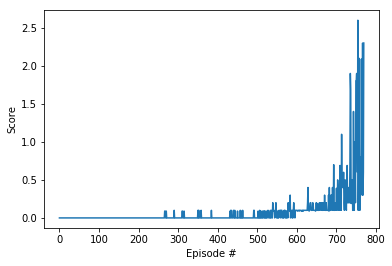

In [30]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [31]:
env.close()